## Modell av lynnedslag på en bil

Et computational essay av Johan Emil Linnestad Larsson

I dette essay-et ønsker jeg å utforske hva som skjer dersom lynet slår ned i noen som sitter i en bil. Fra før av vet vi at feltet inne i et hull i en ideel leder er null, men dette forutsetter at lederen er lukket. Jeg ønsker å finne ut av om man er trygg inne i en bil som har vinduer og hvordan dette påvirker feltet inne i bilen.


Vi begynner med å skrive noe simuleringskode for å løse Poissons ligning for å finne det elektriske potensialet i et område. Metoden vi bruker kalles "method of relaxation", som enkelt forklart går ut på å finne potensialet i et punkt basert på potensialet i nabopunktene. Det vil si at dersom vi definerer grensebetingelsene så vil resten av feltet være gitt.

Vi importerer de modulene vi trenger i Python.

In [44]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import numba


Deretter lager vi en funksjon som kan løse Poissons ligning gitt et sett med grensebetingelser.

In [45]:

@numba.jit
def solve_poisson(Bfield, N):
    """ The function takes Bfield which is a 2d-array of values, where the potential is given as a float for where
    there are a boundary condition, and np.nan where there is no boundary condition. The dimension of Bfield will be the 
    dimension of Vfield. N is the number of iterations.
    """
    
    Vfield = np.zeros_like(Bfield)
    Vfield = np.where(np.isnan(Bfield), Vfield, Bfield)
    dimx = Vfield.shape[0]
    dimy = Vfield.shape[1]
    for n in range(N):
        for ix in range(0,dimx):
            for iy in range(0,dimy):
                if np.isnan(Bfield[ix,iy]):
                    if ix  >= dimx-1:
                        vupper = Vfield[0,iy]
                    else:
                        vupper = Vfield[ix+1,iy]
                    
                    if ix - 1 < 0:
                        vlower = Vfield[dimx-1,iy]
                    else:
                        vlower = Vfield[ix-1,iy]
                    
                    if iy  >= dimy-1:
                        vright = Vfield[ix,0]
                    else:
                        vright = Vfield[ix,iy+1]
                    
                    if iy - 1 < 0:
                        vleft = Vfield[ix,dimy-1]
                    else:
                        vleft = Vfield[ix,iy-1]
                    Vfield[ix,iy] = (vlower+vupper+vright+vleft)/4
                    
                else:
                    Vfield[ix,iy] = Bfield[ix,iy]
        
    
    return Vfield

Vi kan nå sjekke om funksjonen vår fungerer som vi ønsker, vi setter grensebetingelsene langs kantene til å være $V=0 V$, mens i toppen av boksen er $V=10 V$.

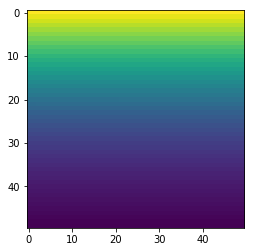

In [46]:
Lx,Ly = 50,50
Bfield = np.zeros((Lx,Ly))
Bfield[:,:] = np.nan
Bfield[:,0] = 10
Bfield[:,-1] = 0
Vfield = solve_poisson(Bfield, 500)

plt.imshow(Vfield.T)


Videre må vi implementere selve lynet. Metoden benytter seg av og finner hvorhen det er mest sansynlig at ladningen beveger seg til. Der det er høyest sansynlighet setter vi potensialet i det punktet til null, og løser deretter poissons ligning engang til. Modellen arbeider fra bakken og oppover, det vil si at vi tenker at det er ladningsforskjell mellom bakken og himmelen. Lynet vil bevege seg til høyere potensialer som vi har i "taket" av simuleringen.

In [47]:
#@numba.jit
def LightningStrike(Vfield, Bfield):
    # Create a copy of the boundary conditions matrix which will be used to check 
    #for possible locations for the lightning's path
    zeroneighbor = np.copy(Bfield) 
    zeroneighbor[:] = 0.0 #set all values in it equal to 0
    #set the values next to the ground equal to 'nan'. This is where the lightning can start
    zeroneighbor[:,Ly-2] = np.float('nan') 
    
    c = np.copy(Vfield)


    nrep = 3000 # Number of jacobi steps
    eta = np.ones_like(Vfield) #A factor that will be used in probability calculation
    ymin = Ly-1 #The y value where we will stop (just above the ground)
    ns = 0
    while (ymin>0): 
        # First find potential on the entire grid, based on the original boundary conditions
        s = solve_poisson(Bfield,nrep)

        # Probability that lightning will move to a new position may depend on potential to power eta
        sprob = s**eta
        # We also multiply by a random number, uniform between 0 and 1, to introduce some randomness
        # And we multiply with isnan(zeroneighbor) to ensure only 'nan' points can be chosen
        sprob = sprob*np.random.uniform(0,1,(Lx,Ly))*np.isnan(zeroneighbor) 

        #now, find the point with max probability 
        [ix,iy] = np.unravel_index(np.argmax(sprob,axis=None),sprob.shape)

        # Update the boundary condition array to set the potential where the lightning is to 0
        Bfield[ix,iy] = 0.0

        # Update neighbor positions of the lightning path to 'nan' (making them possible choices for the next iteration) 
        if (ix>0):
            zeroneighbor[ix-1,iy]=np.float('nan')
        if (ix<Lx-1):
            zeroneighbor[ix+1,iy]=np.float('nan')
        if (iy>0):
            zeroneighbor[ix,iy-1]=np.float('nan')
        if (iy<Ly-1):
            zeroneighbor[ix,iy+1]=np.float('nan')

        ns = ns + 1
        c[ix,iy] = ns #create an array of the lightning's path, scaled by the number of loops
        if (iy<ymin): #iterate to the next set of y-values
            ymin = iy
    return c,s,sprob

In [48]:
c,s,sprob = LightningStrike(Vfield,Bfield)

Text(0, 0.5, 'avstand')

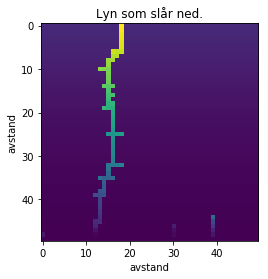

In [49]:
plt.imshow(c.T)
plt.title("Lyn som slår opp.")
plt.xlabel("avstand")
plt.ylabel("avstand")

Dette viser oss hvordan lynnedslaget ser ut. Lynnedslaget er derimot et såkalt ground-to-cloud lynnedslag. Vi kan modellere et cloud-to-ground lynnedslag ved å ganske enkelt snu y-aksen vår og sette potensialet slik at bakken har et potensialet $V=10$ og skyen $V=0$. Dette står vi helt fritt til å gjøre siden vi kan fritt velge hva vi setter som referanse for potensialet, samt at det viktige for den fysiske effekten er potensialforskjellen mellom bakken og jorden.

Vi ønsker nå å tegne en boks, som skal være "bilen" vår. For å simulere en ideel leder så vet vi at feltet inne i lederen skal være null, det betyr at potensialet skal være konstant, så da setter vi alle punktene i det som utgjør en boks til å være konstant lik null.

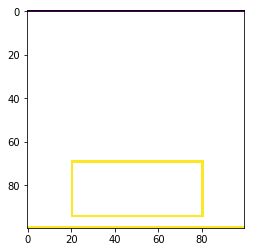

In [50]:
Lx,Ly = 100,100
Bfield = np.zeros((Lx,Ly))
Bfield[:,:] = np.nan
Bfield[:,0] = 10
Bfield[:,-1] = 0


def createcarbox(size):
    Bfield[Lx//2-size,5:size] = 10
    Bfield[Lx//2+size,5:size] = 10

    Bfield[Lx//2-size:Lx//2+size,5] = 10
    Bfield[Lx//2-size:Lx//2+size+1,size] = 10
    


createcarbox(30)
plt.imshow(Bfield.T[::-1,:])

Legg merke til at bilen ikke er i kontakt med bakken. Dette er i tråd med virkeligheten der bilen er isolert fra bakken siden den har gummidekk. En vanlig misforståelse er at biler beskytter mot lynnedslag siden gummihjulene isolerer deg fra bakken, men dette er feil. Vi kan se hva som egentlig skjer av simuleringen under. Vi setter potensialet til å være lik $10 \text{MV}$ som er et anslått potensialdifferanse i et lyn.

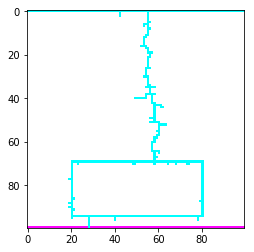

In [51]:
Lx,Ly = 100,100
Bfield = np.zeros((Lx,Ly))
Bfield[:,:] = np.nan
Bfield[:,0] = 10_000_00
Bfield[:,-1] = 0


def createcarbox(size):
    Bfield[Lx//2-size,5:size] = 10_000_000
    Bfield[Lx//2+size,5:size] = 10_000_000

    Bfield[Lx//2-size:Lx//2+size,5] = 10_000_000
    Bfield[Lx//2-size:Lx//2+size+1,size] = 10_000_000
    


createcarbox(30)

Vfield = solve_poisson(Bfield, 1000)


#plt.imshow(Vfield.T[::-1,:])

c,s,sprob = LightningStrike(Vfield,Bfield)

plt.imshow(Bfield.T[::-1,:], cmap = "cool")


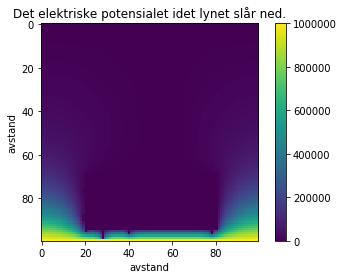

In [52]:
plt.imshow(s.T[::-1,:])
plt.title("Det elektriske potensialet idet lynet slår ned.")
plt.xlabel("avstand")
plt.ylabel("avstand")
plt.colorbar()


Av denne simuleringen ser vi at når lynet treffer bilen så vil bilen avlede lynet rundt bilrammen og ned i bakken, som gir mening mtp at den metalliske lederen er tenkt ideel og vil beskytte dem som sitter inne bilen fra et lynnedslag som vi ser siden potensialet er tilnærmet konstant inne i kabinen av bilen vår noe som betyr at feltet også nødevendigvis må være null. Offisielle råd fra AccuWeather i USA er at dersom man plutselig blir fanget i en tordenstorm skal man være inne i bilen, men man skal ikke ta på bilens metalldeler. En person som er inne i bilen vil før lynnedslaget ha et potensial $V_0$ som er likt det som bilen har. Men som vi ser av simuleringen så vil, under lynnedslaget, bilen endre potensial til $V_b \neq V_0$. Hvis personen også skal endre potensialet betyr det at det må utveklses ladninger, og dersom dette skjer vil det ha fatale konsekvenser. Derfor tenker vi at personen som er inne i bilen er isolert fra bilen metalldeler. Dette er da i tråd med rådet fra AccuWeather. 

### Hva skjer hvis bilen har åpne vinduer?

Vi modifiserer modellen vår av en bil til å ha et åpent vindu.



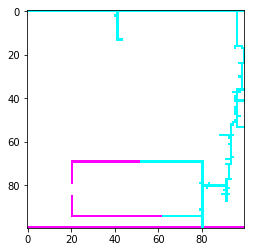

In [53]:
Lx,Ly = 100,100
Bfield = np.zeros((Lx,Ly))
Bfield[:,:] = np.nan
Bfield[:,0] = 10_000_000
Bfield[:,-1] = 0


def createcarboxwithwindow(size):
    Bfield[Lx//2-size,5:size//2] = 10_000_000
    Bfield[Lx//2-size,size//2+5:size] = 10_000_000
    Bfield[Lx//2+size,5:size] = 10_000_000

    Bfield[Lx//2-size:Lx//2+size,5] = 10_000_000
    Bfield[Lx//2-size:Lx//2+size+1,size] = 10_000_000
    


createcarboxwithwindow(30)

Vfield = solve_poisson(Bfield, 1000)


#plt.imshow(Vfield.T[::-1,:])

c,s,sprob = LightningStrike(Vfield,Bfield)

plt.imshow(Bfield.T[::-1,:], cmap = "cool")


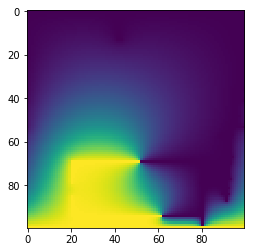

In [54]:
plt.imshow(s.T[::-1,:])

I dette tilfellet ser vi at det er en sterk gradient til potensialfeltet inne i bilen, som betyr at dem som er inne i bilen vil bli utsatt for sterke elektriske krefter som vil være skadelig dersom feltet blir sterkt nok til å få dielektrisk nedbrytning. Fra Wikipedia om Faraday bur, ser vi at for at et faraday-bur skal være fullstendig beskyttende må det være sammenhengde, og hvis det er hull i dem så må hullet være "lite nok" for å blokkere det elektriske feltet.
I vårt tilfelle er tydeligvis vinduet for stort og vil være fatalt for dem som er inne i bilen.
Vi tester å ser hva som er tilfelle hvis vinduet blir lite.

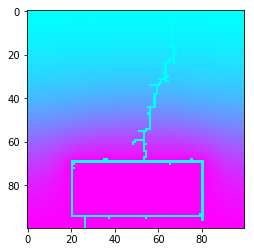

In [55]:
Lx,Ly = 100,100
Bfield = np.zeros((Lx,Ly))
Bfield[:,:] = np.nan
Bfield[:,0] = 10_000_000
Bfield[:,-1] = 0


def createcarboxwithsmallwindow(size):
    Bfield[Lx//2-size,5:size//2] = 10_000_000
    Bfield[Lx//2-size,size//2+1:size] = 10_000_000
    Bfield[Lx//2+size,5:size] = 10_000_000

    Bfield[Lx//2-size:Lx//2+size,5] = 10_000_000
    Bfield[Lx//2-size:Lx//2+size+1,size] = 10_000_000
    


createcarboxwithsmallwindow(30)

Vfield = solve_poisson(Bfield, 1000)


#plt.imshow(Vfield.T[::-1,:])

c,s,sprob = LightningStrike(Vfield,Bfield)

plt.imshow(c.T[::-1,:], cmap = "cool")


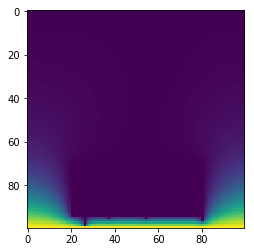

In [56]:
plt.imshow(s.T[::-1,:])

Dette bekrefter det vi leste på wikipedia, her har vi et lite vindu, og lynet klarer å "hoppe" over, slik at det elektriske potensialet er det samme i hele lederen og vi får ikke noe elektrisk felt inne i lederen.

## Modellere vindu

Til nå har vi sett på hva som skjer dersom hullet i bilen bare er luft. Vi vil nå se på hva som skjer dersom vi setter inn glass i åpningen. Vi antar at glasset er et dielektrisk, lineært medium. I modellen vår for lyn ser vi at lynet velger vei basert på hvor stort det elektriske potensialet er i et punkt, opphøyd i en potens eta. 

Luft er vanligvis en isolator, fram til det når sitt dielektriske nedbrytningspunkt og mister sine isolerende egenskaper. Kvalitativt kan vi tenke at det skjer når elektronene i atomene i luften ikke lenger er bundet, og vi får et plasma. Luft har en dielektrisk styrke på $3 \text{MV/m}$.

Ser vi på tilsvarende tall for glass kan vi ser at typiske verdier ligger på mellom $9.8 - 13.8 \text{MV/m}$.

Det vil si at det elektriske feltet som kreves for å få dielektrisk nedbrytning må være $3-4$ ganger sterker enn for luft. Vi kan nå gå tilbake å endre det slik at lynet trenger $\approx 4$ ganger større potensial enn det vill trengt for lufta. (Husk at lynet har potensial $V_l = 0 $ i vår simulering slik at hvis vi tenker på det elektriske feltet rett ved lynet så vil det være potensialforskjellen mellom lynet og punktet vi ser på slik at $3-4$ ganger sterkere felt da vil svare til samme forskjell i potensialet.)

Vi endrer lynnedslag simuleringen:

In [62]:
def LightningStrikeWithGlas(Vfield, Bfield, glassfield):
    # Create a copy of the boundary conditions matrix which will be used to check 
    #for possible locations for the lightning's path
    zeroneighbor = np.copy(Bfield) 
    zeroneighbor[:] = 0.0 #set all values in it equal to 0
    #set the values next to the ground equal to 'nan'. This is where the lightning can start
    zeroneighbor[:,Ly-2] = np.float('nan') 
    
    c = np.copy(Vfield)


    nrep = 3000 # Number of jacobi steps
    eta = np.ones_like(Vfield) #A factor that will be used in probability calculation
    ymin = Ly-1 #The y value where we will stop (just above the ground)
    ns = 0
    while (ymin>0): 
        # First find potential on the entire grid, based on the original boundary conditions
        s = solve_poisson(Bfield,nrep)

        # Probability that lightning will move to a new position may depend on potential to power eta
        sprob = (s*glassfield)**eta
        
        # We also multiply by a random number, uniform between 0 and 1, to introduce some randomness
        # And we multiply with isnan(zeroneighbor) to ensure only 'nan' points can be chosen
        sprob = sprob*np.random.uniform(0,1,(Lx,Ly))*np.isnan(zeroneighbor) 

        #now, find the point with max probability 
        [ix,iy] = np.unravel_index(np.argmax(sprob,axis=None),sprob.shape)

        # Update the boundary condition array to set the potential where the lightning is to 0
        Bfield[ix,iy] = 0.0

        # Update neighbor positions of the lightning path to 'nan' (making them possible choices for the next iteration) 
        if (ix>0):
            zeroneighbor[ix-1,iy]=np.float('nan')
        if (ix<Lx-1):
            zeroneighbor[ix+1,iy]=np.float('nan')
        if (iy>0):
            zeroneighbor[ix,iy-1]=np.float('nan')
        if (iy<Ly-1):
            zeroneighbor[ix,iy+1]=np.float('nan')

        ns = ns + 1
        c[ix,iy] = ns #create an array of the lightning's path, scaled by the number of loops
        if (iy<ymin): #iterate to the next set of y-values
            ymin = iy
    return c,s,sprob

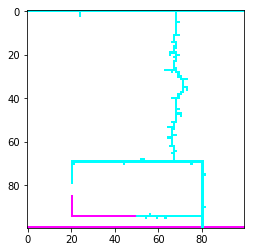

In [98]:
Lx,Ly = 100,100
Bfield = np.zeros((Lx,Ly))
Bfield[:,:] = np.nan
Bfield[:,0] = 10_000_000
Bfield[:,-1] = 0


def createcarboxwithwindow(size):
    Bfield[Lx//2-size,5:size//2] = 10_000_000
    Bfield[Lx//2-size,size//2+5:size] = 10_000_000
    Bfield[Lx//2+size,5:size] = 10_000_000

    Bfield[Lx//2-size:Lx//2+size,5] = 10_000_000
    Bfield[Lx//2-size:Lx//2+size+1,size] = 10_000_000
    
    global glassfield
    glassfield = np.ones_like(Bfield)
    glassfield[Lx//2-size, size//2:size//2+5] = 1/4
    


createcarboxwithwindow(30)

Vfield = solve_poisson(Bfield, 1000)


#plt.imshow(Vfield.T[::-1,:])

c,s,sprob = LightningStrikeWithGlas(Vfield,Bfield,glassfield)

plt.imshow(Bfield.T[::-1,:], cmap = "cool")



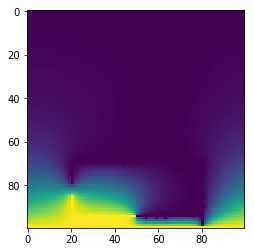

In [99]:
plt.imshow(s.T[::-1,:])

### Hvor stort er feltet? Dødelig?

Vi ser fra Wikipedia at den dielektriske styrken til vann er ca. $65-70 \text{MV / m}$
Vi kan regne ut feltet inne i bilen ved å se på gradienten til spenningen.

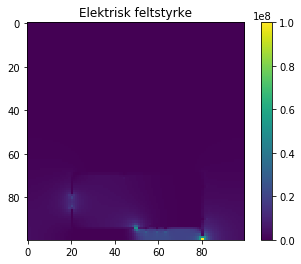

In [105]:

def fieldsinsidecar(s):
    E = np.zeros((2, s.shape[0], s.shape[1]))
    E[:,:,:] = np.asarray(np.gradient(s, 0.1))
    Estrength = np.linalg.norm(E, axis=0)
    return Estrength

plt.imshow(fieldsinsidecar(s).T[::-1])
plt.title("Elektrisk feltstyrke")
plt.colorbar()

Her ser vi at feltstyrken ligger på $\approx 0.2 \text{GV/m}$ på enkelte steder.
Dette er definitivt mer enn den dieletriske nedbrythetskonstanten for vann og jeg vil anta at den er større enn hud også siden kroppen jo består av 70% vann.

For å finne gradienten må vi gi en lengdeenhet, vi tenker oss her at et steg er 10 cm, slik at hele bilen da er 6 m lang. Er bilen mindre blir feltet større.



Vi prøver igjen med mindre vindu.

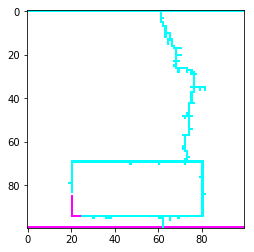

In [95]:
Lx,Ly = 100,100
Bfield = np.zeros((Lx,Ly))
Bfield[:,:] = np.nan
Bfield[:,0] = 10_000_000
Bfield[:,-1] = 0


def createcarboxwithwindow(size):
    Bfield[Lx//2-size,5:size//2] = 10_000_000
    Bfield[Lx//2-size,size//2+1:size] = 10_000_000
    Bfield[Lx//2+size,5:size] = 10_000_000

    Bfield[Lx//2-size:Lx//2+size,5] = 10_000_000
    Bfield[Lx//2-size:Lx//2+size+1,size] = 10_000_000
    
    global glassfield
    glassfield = np.ones_like(Bfield)
    glassfield[Lx//2-size, size//2:size//2+1] = 1/4


createcarboxwithwindow(30)

Vfield = solve_poisson(Bfield, 1000)


#plt.imshow(Vfield.T[::-1,:])

c,s,sprob = LightningStrikeWithGlas(Vfield,Bfield,glassfield)

plt.imshow(Bfield.T[::-1,:], cmap = "cool")

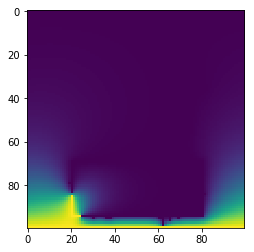

In [96]:
plt.imshow(s.T[::-1,:])

Dette er et heller slående resultat. Selv ikke med et så lite vindu vil bilen være et fullstendig faraday-bur. 


# Konklusjon

Det virker som at det blir farligere å ha vinduer i bilen siden glasset er mer isolerende enn luft og vil da gjøre Faraday-buret vårt enda dårligere og mindre egnet til å beskytte bilens passasjerer. Ved første øyekast kan dette virke motsigende siden vi tenker at en bedre isolator burde isolere det elektriske feltet bedre men slik er det ikke i dette tilfelle, siden vi aller helst vil ha en ideel leder rundt oss for å avlede strømmen trygt ned i bakken.

Jeg tenker at noe av begrensningene ved denne simuleringen er at den var i 2D. Jeg tror at vi bedre kunne får testet mer reelle geometrier dersom vi hadde simulert i 3D. Modellen for forskjellen mellom glass og luft tror jeg er rimelig god gitt de antakelsene vi har. Det som er vanskeligere er at hvis glasset når sin nedbrytning, så vil det generere enormt med varme som vil føre til ekspansjon i glasset som sannsynligvis vil knuse det.

Vi har svært enkelt prøvd å finne det elektriske feltet inne i bilen. Dette viser seg å ha potensialet til å være dødelig, men er svært avhengig av geometrien til hvordan lynet slår ned i bilen.



Det som også gjør lynnedslag så farlig er når strømmen blir ledet gjennom kroppen. Vi antok at bilpassasjerene ikke var i kontakt med metallet i bilen, så dermed er det ingen fare for bilpassasjerene å få strømmen direkte ladet gjennom seg selv. Jeg har i all hovedsak sett på om passasjerene blir utsatt for et elektrisk felt.
Da ser vi med engang at man er mye tryggere inne i en bil enn på flatmark, siden bilen vil avlede strømmen, mens på flatmark vil strømmen gå gjennom mennesket. Allikevel, var valget mellom en bil med store vinduer og ingen vinduer, så er det åpenbart hva som er tryggest.

Den endelige konklusjonen er at bilen sansynligvis hadde vært tryggere uten vinduer og dersom du har vinduer så burde dem være så små som mulige.

Bilde: en bil som faktisk har blitt truffet av et lyn:
(Dagens funfact, det er flere som drukner i biler enn som dør av lynnedslag mens dem er i en bil)


![title](http://bestride.com/wp-content/uploads/2018/07/odyssey-lightning-collier-county-3.jpg)


### Kilder
Faraday- bur : https://en.wikipedia.org/wiki/Faraday_cage

Dielektrisk nebrytningskonstanter: https://en.wikipedia.org/wiki/Dielectric_strength

Bilde og funfact : http://bestride.com/news/are-you-really-safe-from-lightning-inside-a-vehicle